# BERT Model (bert-base-german-cased from Huggingface) for Named Entity Recognition in German Legal Texts

I investigate a dataset containing German federal court decisions annotated with 19 different labels (source: https://github.com/elenanereiss/Legal-Entity-Recognition) and fine-tune 'bert-base-german-cased' from huggingface to recognize these labels. I shall compare the results with Leitner E., Rehm G., Moreno-Schneider J. (2019).


In [1]:
!pip install keras
!pip install scikit-learn
!pip install transformers
!pip install torch torchvision torchaudio
!pip install keras
!pip install seqeval

     |████████████████████████████████| 3.4 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 87.3 MB/s 
     |████████████████████████████████| 895 kB 88.6 MB/s 
     |████████████████████████████████| 61 kB 675 kB/s 
     |████████████████████████████████| 3.3 MB 65.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=2ed7d52da1b1c95ad27c205c4bb0006b0d20418c7596c21da0a627d355005765
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [56]:
import csv
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import BertTokenizer, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertForTokenClassification, AdamW
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm, trange

## 1. Load data

Create a csv-file and fill it with the data from ConLL files

In [5]:
# create an empty csv via a pandas dataframe and write lines from CoNLL files in directory
df = pd.DataFrame(list())
df.to_csv('data.csv')

with open('data.csv', 'w') as data:
  data.write('running_text|word|tag\n')
  text = 0
  for item in os.listdir('./data/dataset_courts'):
    with open('./data/dataset_courts/'+item, 'r') as file:
      for line in file.readlines():
        if line == '\n':
          text += 1
        elif len(line.split())==2:
          word, tag = line.split()
        else:
          word, tag = [" ", line.strip()]
        data.write(f"{str(text)}|{word}|{tag}\n")

Read csv files to dataframe

In [6]:
# create a dataframe and fill running_sentence column
data = pd.read_csv('data.csv', delimiter='|', quoting=3).fillna(method='ffill')
data.tail(10)

,running_text,word,tag
2223761,66722,m.,I-GS
2223762,66722,§,I-GS
2223763,66722,20,I-GS
2223764,66722,Abs.,I-GS
2223765,66722,1,I-GS
2223766,66722,Satz,I-GS
2223767,66722,1,I-GS
2223768,66722,WBO,I-GS
2223769,66722,.,O
2223770,66723,.,O


The joined dataset contains 66723 sentences (or texts, called "sentences" from here on)

## 2. Basic exploration of the data (EDA)

### 2.1 Frequencies of types of annotation labels

Word-labels at the beginning of an annorated expression in a sentence start with "B-...", the following words of the expression start with "I-...", unlabelled words are tagged as "O". Counting tags is done by counting the occurrences of "B-..." .

First, I create a new colum that determines whether a tag is a startertag. I ignore the overwhelming majority of untagged expressions and create a dataframe that contains only "B-..." tags, clean them, and receive readable tag names.



The different annotations are not balanced with respect to their frequency. 'GS' occurs 18522 times, 'AN' only 111 times.

In [7]:
df = data
df['startertag'] = df.tag.str.startswith('B')

df1 = df[df.startertag == True]
df1['tag'] = df1.tag.apply(lambda x: x if x == 'O' else x.split('-')[-1])

df2 = df1.groupby('tag').size().sort_values(ascending=False).reset_index(name='counts')
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tag,counts
0,GS,18522
1,RS,12580
2,GRT,3217
3,LIT,3006
4,VT,2863
5,RR,2507
6,INN,2197
7,PER,1759
8,EUN,1500
9,LD,1437


Text(0.5, 1.0, 'Frequency of Annotation Labels in Corpus')

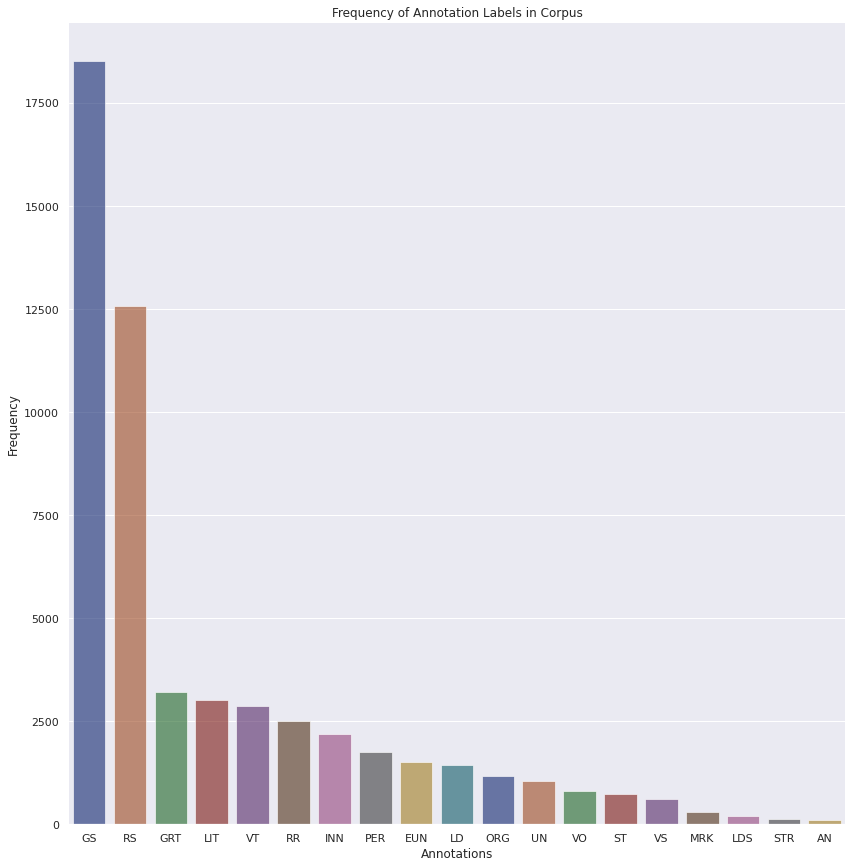

In [8]:
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,10)

g = sns.catplot(
    data=df2, kind="bar",
    x="tag", y="counts",
    ci="sd",
    palette="dark",
    height=12,
    alpha=.6
    )
g.despine(left=True)
g.set_axis_labels("Annotations", "Frequency")
g.set_xticklabels()
plt.title("Frequency of Annotation Labels in Corpus")

### 2.2 Further observations

How many expressions have been labelled in a sentence? There are about 1.8 such expressions per annotated sentence (annotations often comprising more than one word).

In [9]:
df3 = df1.groupby('running_text').size().reset_index(name='counts')
df3.head(20)

,running_text,counts
0,1,2
1,3,2
2,4,2
3,5,3
4,6,3
5,7,1
6,8,1
7,9,1
8,10,1
9,13,1


In [10]:
annotations_per_sentence = df3.counts.sum()/len(df3)
annotations_per_sentence.round(2)

1.8

Close to a fifth of the words in the dataset are labelled.

In [11]:
df4 = df
# register if a word is labelled (1) or not (0)
df4['label'] = df4.tag.apply(lambda x: 0 if x == 'O' else 1)
# fill a column with 1s to count words per sentence
df4['textlength'] = df.tag.apply(lambda x: 1)
labelled_words = df4.label.sum()/df4.textlength.sum()
labelled_words.round(2)

0.19

More than half of the sentences contain no annotations.

In [12]:
df5 = df4.groupby('running_text')[['label', 'textlength']].sum().reset_index()
text_annotation_rate = len(df5[df5.label == 0])/len(df5)
text_annotation_rate

0.5446915652538816

The average word-length of a sentence is 33.3

In [13]:
df_words_per_text = df5.textlength.sum()/len(df5)
df_words_per_text.round(2)

33.33

The dataset seems to be consistenly labelled, the number of labelled words being clearly correlated to the lengths of the sentence. Hence, the dataset seems suitable for training a language model for NER.

Text(0, 0.5, 'number of words')

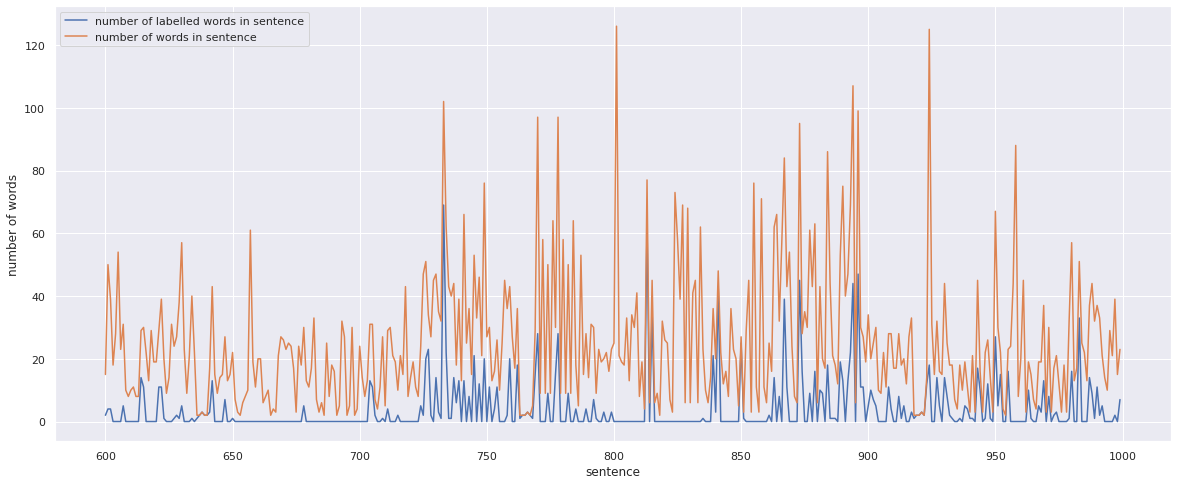

In [14]:
plt.figure(figsize = (20, 8))

plt.subplot()
sns.lineplot(x="running_text", y="label", data=df5[600:1000], label="number of labelled words in sentence")
sns.lineplot(x="running_text", y="textlength", data=df5[600:1000], label="number of words in sentence")
plt.xlabel("sentence")
plt.ylabel("number of words")

## 3. Preprocessing sentences for tokenization with BERT

### 3.1 Prepare dataset for tokenization

Many of the following steps take guidance from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [15]:
# Iterator that takes out dataframe an delivers sentences as lists of word/tag-pairs
class GetSentence(object):
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        # create column that contains sentences as lists of word-tag-pairs
        self.grouped = self.data.groupby('running_text').apply(lambda x: [(word, tag) for word, tag in zip(x.word.values.tolist(), x.tag.values.tolist())])
        # create list of sentences
        self.sentences = [sentence for sentence in self.grouped]

    def get_next(self):
        '''
        function to generate sentences from the list self.grouped'''
        try:
            sentence = self.grouped[f"{self.n_sent}"]
            self.n_sent += 1
            return sentence
        except:
            return None


iterator = GetSentence(data)

Create new lists by separating the word-tag tuples and attach the special tokens 'SEP' and 'CLS' as unlabelled expressions as required by BERT.

In [16]:
# list all sentences as wordlists and append special tokens
sentences_wordlists = [[item[0] for item in sentence] for sentence in iterator.sentences]
for sentence in sentences_wordlists:
  sentence.append('[SEP]')
  sentence.insert(0, '[CLS]')

In [17]:
# list lists of tags for all sentences and append 'O' for not annotated
sentences_tagslists = [[item[1] for item in sentence] for sentence in iterator.sentences]
for tagslist in sentences_tagslists:
  tagslist.append('O')
  tagslist.insert(0, 'O')

In [18]:
'''# Due to limited resources, data are trained on a subset of the data. A new dataframe is shuffled before we re-extract separated lists of lists of words and tags.
df = pd.DataFrame({'sentence': sentences_wordlists, 'tag': sentences_tagslists})
df_shuffled = df.sample(frac=1)
df = df_shuffled.reset_index(drop=True)[:8000]
train_sentences = df.sentence.values.tolist()
train_labels = df.tag.values.tolist()'''

### 3.2 Tokenization

Tokenization by BERT creates subwords from unfamiliar words. These subwords should receive the same tag.

In [19]:
MODEL_NAME = 'bert-base-german-cased'
#tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

In [20]:
def bert_tokenize(sentence, wordtags):
  '''
  function to apply BERT tokenizer to the words in our sentences
  multiplies word-tags by the subword length to receive matching labels for all subwords that
  result from the tokenization
  returns two lists: a list of lists of tokenized sentences and a list of lists of mapping labels
  '''
  
  tokenized_sentences = []
  tags = []
  for word, tag in zip(sentence, wordtags):
    # tokenizewords
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentences.extend(tokenized_word)
    # multiply tag by length of subwordlist
    tags.extend([tag]*n_subwords)

  return tokenized_sentences, tags

Apply the tokenization function, resulting in prpoper pairings of tokenized words an labels.

In [21]:
sentence_tags_pairs_tokenized = [bert_tokenize(words,tags) for words,tags in zip(sentences_wordlists, sentences_tagslists)]

Separate the above list of tokenized pairs into lists of words and list of list of labels to enable transfer learning

In [23]:
sentences_tokenized = [pair[0] for pair in sentence_tags_pairs_tokenized]
labels = [pair[1] for pair in sentence_tags_pairs_tokenized]

### 3.3 Preprocessing for transfer learning

### 3.3.1 Input ids, padding and attention masks

To get our data in shape as inputs for transfer learning with BERT we need to create input ids, sentence padding and attention masks.

In [24]:
MAX_LEN = 75
BATCH_SIZE = 32

# list the unique tags from the tag-column
tag_values = list(set(data['tag'].values))
tag_values.append('PAD')
# create dictionary for tags and their index values in tag_values
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [25]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences_tokenized],
                          maxlen=MAX_LEN,
                          dtype='long',
                          value=0.0,
                          truncating="post",
                          padding="post")

'[CLS]' and '[SEP]' get represented as "3" and "4" in the input ids.

In [26]:
input_ids[0]

array([    3, 12663,  2821, 26935, 14094,   142,   204,  8696,  3040,
        6876, 26935,  8204,  2668,     4,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [27]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN,
                     value=tag2idx["PAD"],
                     padding="post",
                     dtype="long",
                     truncating="post")

In [28]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
attention_masks = np.array(attention_masks)

### 3.3.2 Train-test-splits, tensor datasets, data loaders

In [29]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=0,
                                                            test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=0,
                                             test_size=0.1)


In [30]:
# transform train data from arrays to tensors
tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

# transform validation data from arrays to tensors
val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

In [31]:
# create tensor dataset, data loader and sequential sampler objects

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

## 4. Load and train model

### 4.1 Choose model and set training parameters

In [32]:
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False)

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-b

In [33]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# pass model parameters to GPU
model.cuda();

In [34]:
# specify paramaters the optimizer should update

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [65]:
EPOCHS = 3
MAX_GRAD_NORM = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * EPOCHS

# Choose optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
    )

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

### 4.2 Train model

The training and validation loops are taken from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [66]:
# Store the average loss after each epoch so we can plot them.

loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}\n".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [[tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]]
    valid_tags = [[tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]]
    
    print('Validation accuracy:\t{:.5f}'.format(accuracy_score(pred_tags, valid_tags)))
    print('Validation precision:\t{:.5f}'.format(precision_score(pred_tags, valid_tags)))
    print('Validation recall:\t{:.5f}'.format(recall_score(pred_tags, valid_tags)))
    print('Validation f1-score:\t{:.5f}'.format(f1_score(pred_tags, valid_tags)))

    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.003372299048958261

Validation loss: 0.03334256651699447
Validation accuracy:	0.99483
Validation precision:	0.95301
Validation recall:	0.93192


Epoch:  33%|███▎      | 1/3 [08:49<17:39, 530.00s/it]

Validation f1-score:	0.94235

Average train loss: 0.0020013004648981063

Validation loss: 0.03166877499679425
Validation accuracy:	0.99500
Validation precision:	0.95567
Validation recall:	0.94349


Epoch:  67%|██████▋   | 2/3 [17:39<08:49, 529.50s/it]

Validation f1-score:	0.94954

Average train loss: 0.0008234498346630888

Validation loss: 0.03142908587125765
Validation accuracy:	0.99535
Validation precision:	0.95820
Validation recall:	0.94860


Epoch: 100%|██████████| 3/3 [26:27<00:00, 529.21s/it]

Validation f1-score:	0.95338



Save the model for later use.

In [67]:
torch.save(model.state_dict(), 'LegalBERTmodel3e')

### 4.3 Loss, classification report

Print a loss curve based on the training and validation losses of each epoch.

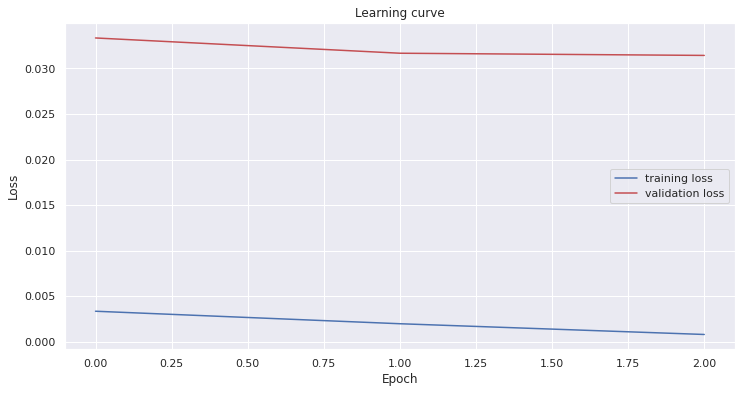

In [68]:
sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b', label="training loss" )
plt.plot(validation_loss_values, 'r', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Precision, recall and f1-score for categories ('AN' missing, because due to class size, the model was not able to deliver any values for that class)

In [69]:
from seqeval.metrics import classification_report as crs
print(crs(valid_tags, pred_tags))

              precision    recall  f1-score   support

          AN       1.00      0.92      0.96        13
         EUN       0.98      0.96      0.97       288
         GRT       0.98      0.98      0.98       544
          GS       0.98      0.98      0.98      2264
         INN       0.91      0.95      0.93       424
          LD       0.98      0.97      0.98       165
         LDS       0.71      0.79      0.75        19
         LIT       0.93      0.95      0.94       461
         MRK       0.75      0.73      0.74        70
         ORG       0.85      0.88      0.87       243
         PER       0.91      0.95      0.93       243
          RR       0.99      1.00      0.99       647
          RS       0.97      0.96      0.97      1118
          ST       0.77      0.99      0.87        87
         STR       0.85      0.48      0.61        23
          UN       0.93      0.89      0.91       209
          VO       0.85      0.89      0.87       131
          VS       0.85    

## 5. Comparison to results from Leitner, Rehm & Moreno-Schneider*

The above BERT transfer learning model outperforms the CRF-F, CRF-FG and CRF-FGL as well as the BiLSTM-CRF BiLSTM-CRF+ and BiLSTM-CNN-CRF models trained by the authors.


*Leitner E., Rehm G., Moreno-Schneider J. (2019) Fine-Grained Named Entity Recognition in Legal Documents. In: Acosta M., Cudré-Mauroux P., Maleshkova M., Pellegrini T., Sack H., Sure-Vetter Y. (eds) Semantic Systems. The Power of AI and Knowledge Graphs. SEMANTiCS 2019. Lecture Notes in Computer Science, vol 11702. Springer, Cham. https://doi.org/10.1007/978-3-030-33220-4_20

## 6. Function to annotate new sentences

This function can test new sentences.

In [70]:
def test_new_sentence(sentence):

    '''
    tokenize, encode an input sentence and predict labels,
    return df with the input and predicted labels
    '''
    
    new_tokens, new_labels = [], []

    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence])

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    for token, label in zip(new_tokens, new_labels):
        df = pd.DataFrame({'Sentence': new_tokens, 'Label': new_labels})
    
    return df#.transpose()

### Resources

Leitner, E., Rehm, G., and Moreno-Schneider, J. (2019).Fine-grained Named Entity Recognition in legal documents.

Leitner, E., Rehm, G., and Moreno-Schneider, J. (2020). A Dataset of German Legal Documents for Named Entity Recognition

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/